# Leave-One-Unit-Out Evaluation of Performance-Metric RUL Prediction

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt
import copy 
import imageio

from src.models.particle_filter.core import ParticleFilter
from src.models.networks.pf_mlp import ParticleFilterMLP
from src.models.rul_predictor import RULPredictor

from src.helpers.visualization import create_rul_prediction_frame,plot_rul_from_dataframe
from src.helpers.seed import set_global_seed

from experiment_config import (
    DegModel,DATA_NAME,ESTIMATION_NAME,SEED,PFNET_NAME,LEAKY_SLOPE,HIDDEN_DIMS,PREDICTION_START_IDX, UNCERTAINTY_LEVEL
)

## Parameters

In [2]:
n_particles = 1800

## Plot resolution
t_grid = np.linspace(0.1, 100, 80) 
s_grid = np.linspace(0.0, 1.0, 60)


## Hyper-Parameters

In [3]:
activation = torch.nn.LeakyReLU(LEAKY_SLOPE)

set_global_seed(SEED)
estimation_dir = Path('experiments')/DATA_NAME/ESTIMATION_NAME
degmodel_dir = estimation_dir/DegModel.name()
pfnet_dir = degmodel_dir /'pf_performs'/PFNET_NAME

## Import development data


In [4]:
hi_df = pd.read_csv(estimation_dir/'data_dev.csv')
del hi_df['hs']
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 4, 5, 6]

In [5]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Prepare data

In [6]:
eval_data = {}
for name, perform_units in performs.items():
    eval_perform_data = {}
    for unit in units:
        t_data = time[unit]
        s_data = perform_units[unit]
        eval_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    eval_data[name]=eval_perform_data

## Load pf-models

In [7]:
pfs = {}
for perform_name in perform_names:
	perform_pfs = {}
	net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=HIDDEN_DIMS,
                        activation=lambda : activation)
	ckpt = torch.load(pfnet_dir/perform_name/'checkpoint.pt', weights_only=False)
	net.load_state_dict(ckpt['model_state'])
	net = net.eval() 
	
	degmodels = []
	for unit in units:
		best_model = DegModel()
		best_model.load_state_dict(
			torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
		)
		degmodels.append(best_model)
  
	for eval_unit in units:
		train_degmodels = [copy.deepcopy(model) for i, model in enumerate(degmodels) if units[i] != eval_unit]
		perform_pfs[eval_unit] = ParticleFilter(
      										base_models = train_degmodels,
                                            net = net,
                                            n_particles=n_particles)
	pfs[perform_name] = perform_pfs

## Create System RULs

In [8]:
rul_preds:dict[int,RULPredictor] = {}
for unit in units:
	pf_models = {name: pfs[name][unit] for name in perform_names}
	rul_preds[unit] = RULPredictor(pf_models=pf_models,current_obs=False,conf_level=UNCERTAINTY_LEVEL)

## System RUL

In [9]:
preds:list[pd.DataFrame] = []  
for eval_unit,rul_pred in rul_preds.items():
    s_data = {name: performs[name][eval_unit] for name in perform_names}
    t_data = time[eval_unit]
    eol_time = time[eval_unit][-1]

    frames = []

    def video_callback(k:int,rul_pred: RULPredictor):
        frames.append(
            create_rul_prediction_frame(
                rulpred=rul_pred,
                t_grid=t_grid,
                s_grid=s_grid,
                t_data_np=t_data,
                s_data_np=s_data,
                step=k,
                eol_time=eol_time,
                unit=eval_unit,
                dist_vmax=0.3,
                dist_legend_loc="lower left",
                dist_plot_mean=False,
            )
        )

    rul_pred.predict(
		t_data=t_data,
		s_data=s_data,
		start_idx=PREDICTION_START_IDX,
		on_step=video_callback, # optional callback to create video frames
	)
    df = rul_pred.history_to_dataframe()
    df["unit"] = eval_unit
    df["true_rul"] = np.maximum(eol_time - df['time'], 0.0)
    preds.append(df)
    # Save video
    if frames:
        video_path = pfnet_dir/f'rul_pred_eval{eval_unit}.mp4'
        with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
            for frame in frames:
                writer.append_data(frame)

        print(f"🎬 Video saved to {video_path}")
preds_df = pd.concat(preds, ignore_index=True)
preds_df.to_csv(pfnet_dir / "rul_eval_predictions.csv", index=False)

🎬 Video saved to experiments/DS01/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/rul_pred_eval1.mp4
🎬 Video saved to experiments/DS01/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/rul_pred_eval2.mp4
🎬 Video saved to experiments/DS01/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/rul_pred_eval4.mp4
🎬 Video saved to experiments/DS01/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/rul_pred_eval5.mp4
🎬 Video saved to experiments/DS01/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/rul_pred_eval6.mp4


# Plot final RUL prediction

In [10]:
preds_df= pd.read_csv(pfnet_dir / "rul_eval_predictions.csv")

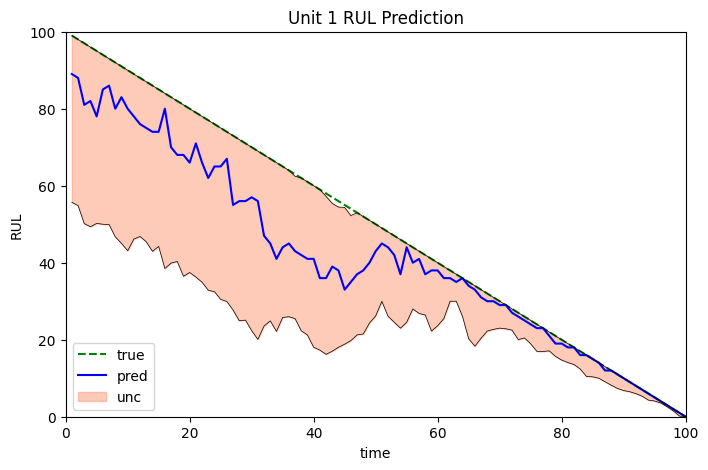

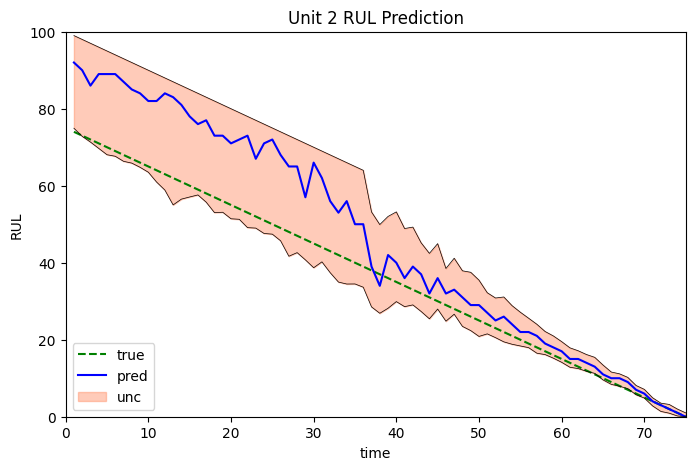

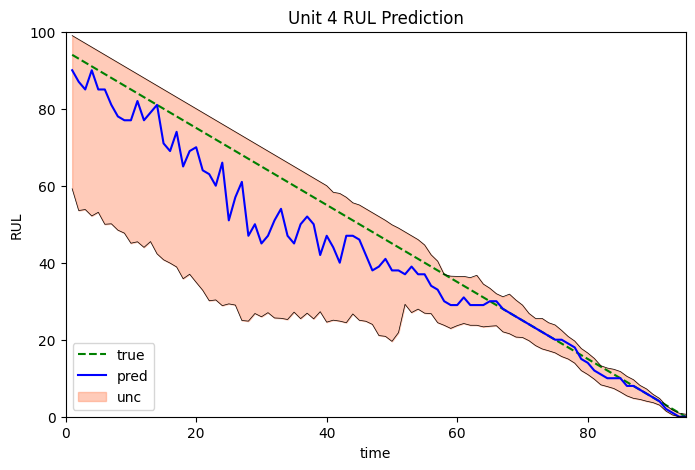

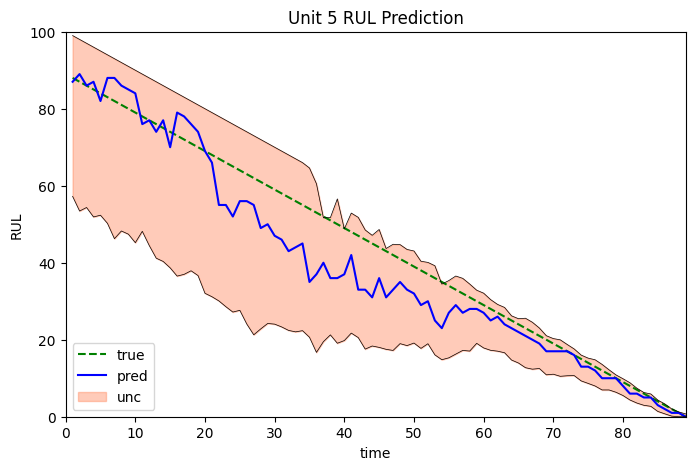

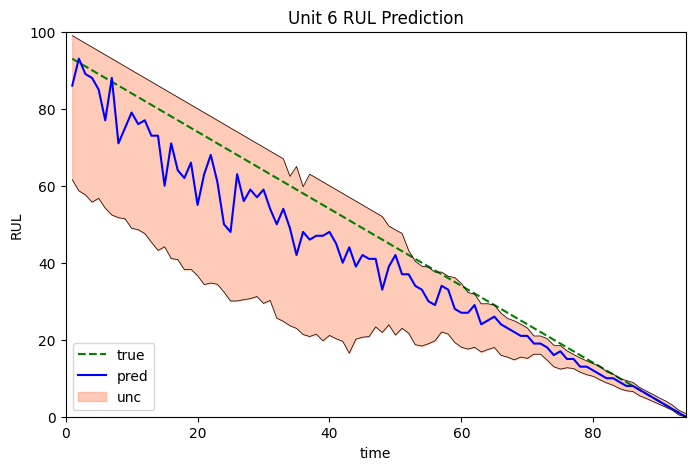

In [11]:
for unit in units:
	fig, ax = plt.subplots(figsize=(8, 5))
	df = preds_df[preds_df['unit']==unit]
	eol_time = df['time'].iloc[-1]
	plot_rul_from_dataframe(ax=ax, df=preds_df[preds_df['unit']==unit], t_max=eol_time, 
			title=f"Unit {unit} RUL Prediction")
	fig.savefig(pfnet_dir / f'rul_pred_eval{unit}.png')